# Using CVXPY for Regression with Time-Variant Coefficients
## Prepared by Patrick Lerchi for TS1 Group
## Data-X, Spring 2018

In this code, we seek to solve the following optimization problem:

$\displaystyle \min\limits_{\theta(t)} \sum_{t=1}^N ||y(t) - \phi^T(t)\theta(t)||^2 + \lambda \sum_{t=2}^N ||\theta(t) - \theta(t-1)|| k$

Our implementation uses CVXPY, and mirrors the method used in the Stanford Paper:

Segmentation of ARX-models using sum-of-norms regularization

Henrik Ohlsson, Lennart Ljung and Stephen Boyd

### Step 0: Install & Test CVXPY

The code will NOT work unless cvxpy is installed in your environment!

TERMINAL INPUT: <br>
conda install -c cvxgrp cvxpy libgcc <br>
conda install nose (installs test function) <br>
nosetests cvxpy (tests the functionality of cvxpy)

### Step 1: Load Data, Visualize Features

#### What is actually happening in the test data?

The Stanford Paper uses a pre-defined Matlab file called 'iddemo6m.mat'. We have converted it into an excel file and uploaded it as 'Example.csv'. The example problem has 3 features and 38 observations with an output of the following form:

$$ y(t) + 0.9y(t-1) = u(t-n_k) + e(t) $$

From the paper: "The input u is a ±1 PRBS signal and the additive noise has variance 0.1. At time t = 20, the time delay nk changes from 2 to 1."

We train our model with data for $y(t-1)$, $u(t-1)$, and $u(t-2)$. These measured quantities represent our three features, which will be optimally fit by the time varying coefficients ($a$, $b_1$, and $b_2$).

$$ y(t) + ay(t − 1) = b_1u(t − 1) + b_2u(t − 2)$$

Since the time delay of u changes at t=20, we expect $b_1$ to equal one during the first twenty seconds before turning off. Conversely, $b_2$ should start at zero, and turn on after twenty seconds. Coefficient $a$ should equal -0.9 during the duration of this study. Note that our example file also contains the actual test output, $y(t)$. Let's get started!

In [1]:
# General Notebook Setup
import cvxpy as cvx
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

# INPUT FILE FORMAT:
# M rows of observations x N feature columns
# First Row = Feature Names
# Last Column = Dependent Variable (Y)
test = pd.read_csv('Example.csv')

# Process dataframe into usable components
T = range(len(test))
F = test.iloc[:,0:-1]
Y = test.iloc[:,-1]
[M,N] = np.shape(test) # Shows M observations and N+1 features
N-=1
print('Dataframe Size:',np.shape(test))
print('There are', M, 'observations and', N, 'features.')

Dataframe Size: (38, 4)
There are 38 observations and 3 features.


In [2]:
test.head()

,-Y(t-1),u(t-1),u(t-2),Y(t)
0,0.38884,1,1,0.27952
1,-0.27952,1,1,1.89440
2,-1.89440,-1,1,3.01130
3,-3.01130,-1,-1,1.92210
4,-1.92210,-1,-1,0.86275


Y(t)


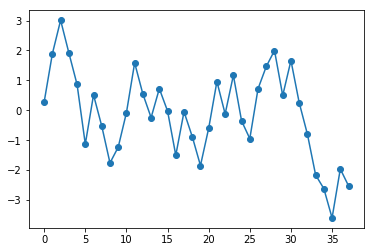

In [3]:
# Plot an individual feature by name
featNAME = 'Y(t)'
plt.plot(test[featNAME],'-o')
print(featNAME)
plt.show()

Y(t)


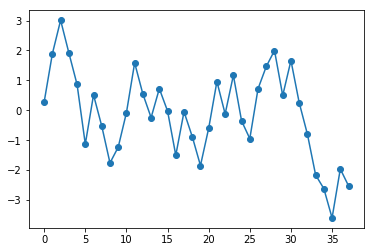

In [4]:
# Plot an individual feature by index
colIDX = 3
graphCOL = test.iloc[:,colIDX]
colname = test.columns[colIDX]
print (colname)
plt.plot(T,graphCOL,'-o')
plt.show()

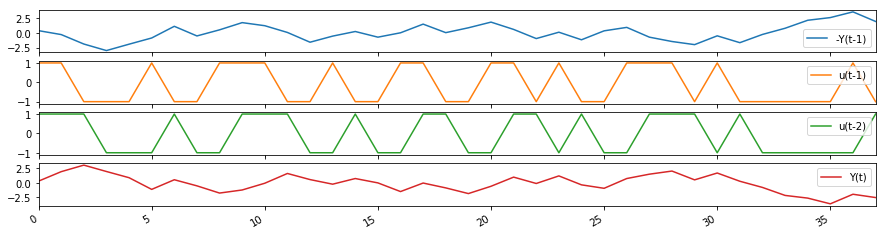

In [5]:
# Plot all features + output
test.columns.tolist()
test.plot(subplots=True, figsize=(15, 4)); # Plotting Individual Columns
plt.show()

### Step 2: Calculate the Maximum Useful Penalty, $\lambda_{max}$ 

In [6]:
# Initialize features and output as numpy arrays
Ynp = Y.values
Fnp = F.values

In [7]:
# Find YF product
sumYF = np.zeros((1,1))
Ymat = np.tile(Ynp, (N, 1)).transpose() # Copy Y array into a [MxN] matrix
sumYF = np.sum(np.multiply(Ymat,Fnp),axis=0)

In [8]:
# Find FF product
sumFF = np.zeros((N,N))
for t in range(M):
    temp = np.zeros((N,N))
    for idx1 in range(N):
        for idx2 in range(N):
            temp[idx1,idx2] = Fnp[t,idx1]*Fnp[t,idx2]
    sumFF = sumFF + temp
sumFF

array([[76.06585004, 13.607161  , -5.173341  ],
       [13.607161  , 38.        ,  0.        ],
       [-5.173341  ,  0.        , 38.        ]])

In [9]:
# Solve the linear system
ThetaC = np.linalg.solve(sumFF,sumYF)
ThetaC

array([-0.73173837,  0.47487534,  0.44747392])

In [10]:
# Norms of ThetaC for each observation
T = np.zeros((M,N))
Tnorm = np.zeros(M)

T[0] = 2*(Y[0]-np.dot(Fnp[0],ThetaC))*Fnp[0]
Tnorm[0] = np.linalg.norm(T[0])

for t in range(1,M-1):
    T[t] = T[t-1] + 2*(Y[t]-np.dot(Fnp[t],ThetaC))*Fnp[t]
    Tnorm[t] = np.linalg.norm(T[t])
    
Tnorm

array([ 1.05103452,  1.3566562 ,  8.47043561, 11.81279946, 13.25650364,
       13.50431996, 15.01478441, 15.02803262, 19.22977773, 20.98272562,
       21.17091366, 25.12162395, 25.71168327, 27.06930079, 29.27552529,
       29.67846618, 33.62453111, 33.43042047, 31.32519116, 31.35445684,
       28.5727147 , 28.18654993, 25.61846336, 22.22173165, 18.38097187,
       18.50456864, 14.47569585, 14.46379276, 14.46032511, 12.37183859,
        8.93363009,  8.30856173,  8.23068089,  6.74930327,  6.3453772 ,
        4.84588975,  5.14012146,  0.        ])

In [11]:
lambda_max = max(Tnorm)
LamRatio = 0.1
LAMBDA = LamRatio * lambda_max
print('lambda max:',lambda_max)
print('lambda:',LAMBDA)

lambda max: 33.62453110732181
lambda: 3.362453110732181


### Step 3: Set up and solve CVX problem

In [12]:
# Build X matrix
X = np.zeros((M,M*N))
X[0,range(3)] = Fnp[0]
for i in range(2,M+1):
    X[i-1] = np.append(np.append(np.zeros((N*(i-1))),Fnp[i-1]), np.zeros((1,N*M-N*(i-1)-N))[0])
np.shape(X)

(38, 114)

In [13]:
theta = cvx.Variable(N,M)
# Final Command 
objective = 0
for i in range(M):
    objective = objective + cvx.norm(Y[i] - Fnp[i,:]*theta[:,i])**2 
for i in range(1,M):
    objective = objective + LAMBDA*cvx.norm(theta[:,i]-theta[:,i-1])


objective_sol = cvx.Minimize(objective)
prob = cvx.Problem(objective_sol)
result = prob.solve()

In [14]:
print(theta.value)
np.shape(theta.value)

[[-0.95036273 -0.95036273 -0.95036273 -0.95036273 -0.95036273 -0.95036273
  -0.95036273 -0.95036273 -0.95036273 -0.95036273 -0.95036273 -0.95036273
  -0.95036274 -0.96339195 -0.96339195 -0.96339195 -0.96339195 -0.78387058
  -0.78387058 -0.78387057 -0.78387057 -0.78387057 -0.78329055 -0.78129238
  -0.78129238 -0.78129238 -0.78129238 -0.78129238 -0.78129238 -0.78129238
  -0.78898544 -0.78898544 -0.78898544 -0.79417272 -0.79417272 -0.79417272
  -0.79417272 -0.79417272]
 [-0.1746435  -0.1746435  -0.1746435  -0.1746435  -0.1746435  -0.1746435
  -0.1746435  -0.1746435  -0.1746435  -0.1746435  -0.1746435  -0.1746435
  -0.17464349 -0.06999297 -0.06999297 -0.06999297 -0.06999297  0.97938674
   0.97938676  0.97938677  0.97938678  0.97938678  0.99470117  1.04745974
   1.04745974  1.04745974  1.04745974  1.04745974  1.04745974  1.04745974
   1.0512716   1.0512716   1.0512716   1.05318095  1.05318095  1.05318095
   1.05318095  1.05318095]
 [ 1.12430215  1.12430215  1.12430215  1.12430215  1.1243021

(3, 38)

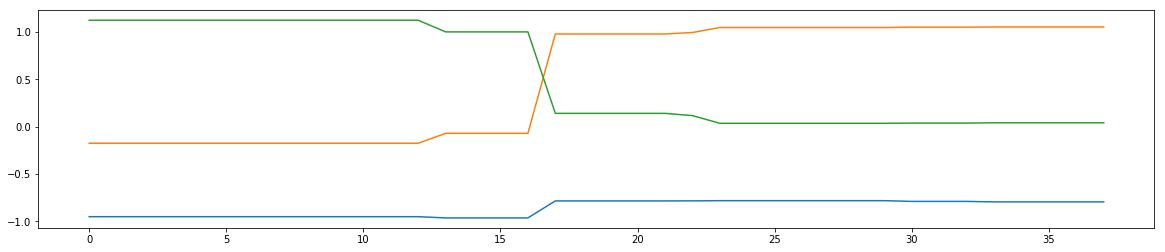

In [15]:
plt.figure(figsize = (20,4))
plt.plot(theta.value.T)
plt.show()